# Quantifying semisc similarity
## Chapter 031-Image-retrieval

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [ ]:
### Loading and preparing dataset

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data

#load  seimsic data
chapterName = "031-Image-retrieval-PCA"
prevChapterName = "02-data_sequence_analysis"
input_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + prevChapterName
output_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + chapterName
data_cube = np.load("/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/data/processed/f3_entire_int8.npy")

print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

img shape (651, 951, 462)
651 951 462


In [13]:
### Dimension reduction and visualization with PCA

In [2]:
# flatten directions 
data = flatten_directional_data(data, num_samples)
print("flattten dirs", data["inline"].shape, data["xline"].shape, data["tline"].shape )
# perform PCA for each dir 

flattten dirs (651, 439362) (951, 300762) (462, 619101)


In [3]:
def perform_pca(data):
    pca_digits=PCA(2)
    pca = pca_digits.fit_transform(data) 
    print("explained_variance_ratio", np.sum(pca_digits.explained_variance_ratio_))
    return pca

pca = {}

for dir in directions:
    filename = input_folder + "/pca_" + dir + ".npy"
    if not os.path.exists(filename):
        print("did not find data.. creating new...")
        pca[dir] = perform_pca(data[dir]) 
        # store the data 
        np.save(filename, pca[dir])
    else:
        print("found data. loading it to memory")
        pca[dir] = np.load(filename)

found data. loading it to memory
found data. loading it to memory
found data. loading it to memory


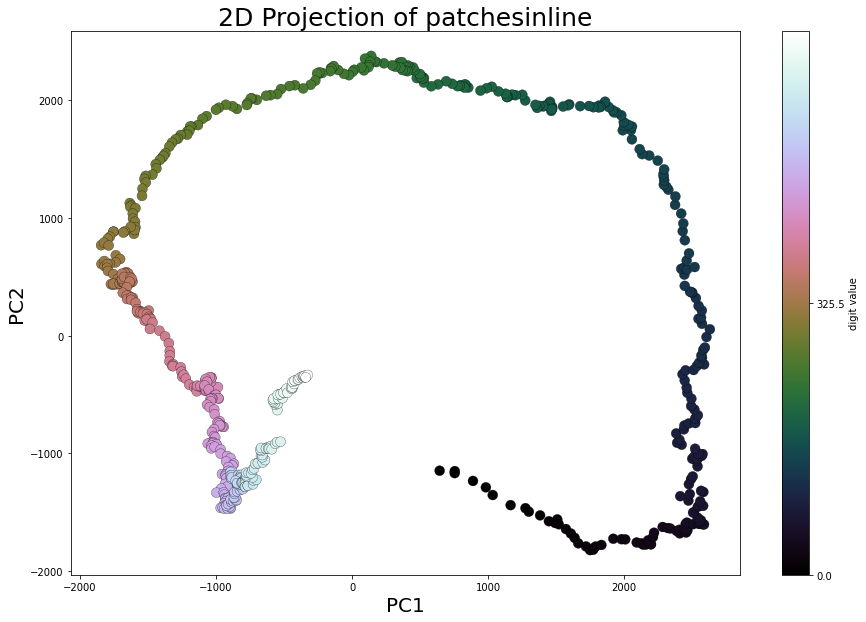

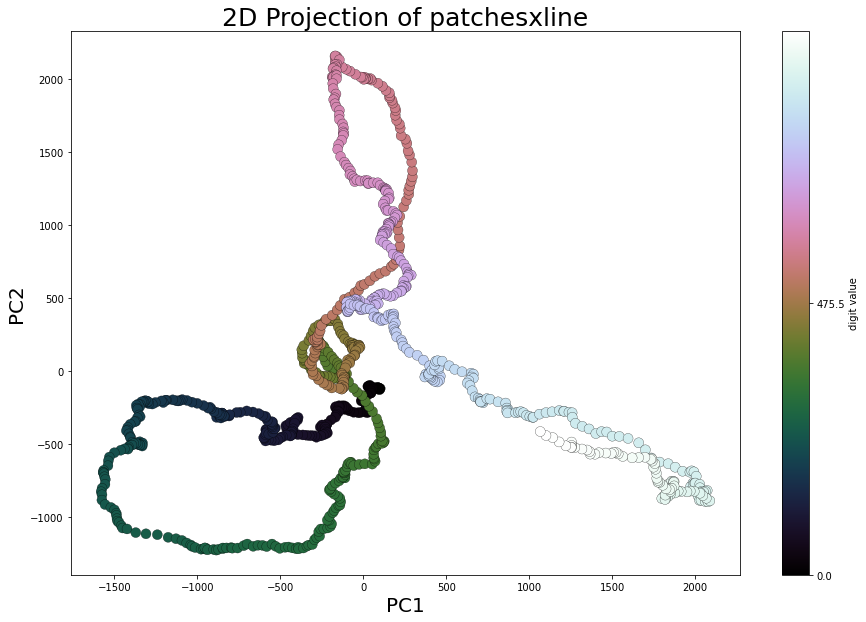

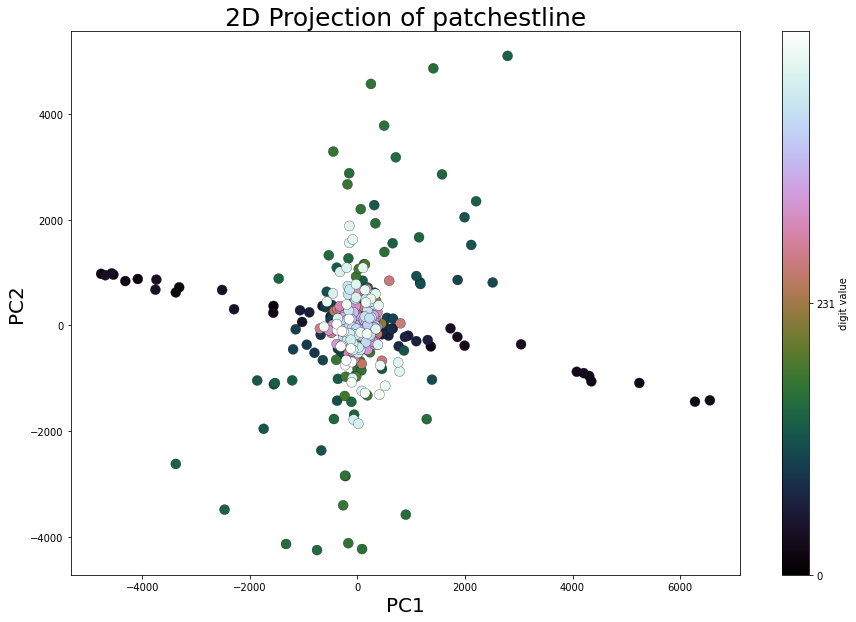

In [4]:
# scatter the different images with the original label     
for dir in directions:
    scatter(pca[dir], labels[dir], num_samples[dir], dir, show_labels=False)

    

pca[dir] (651, 2)
pca[dir] (951, 2)
pca[dir] (462, 2)


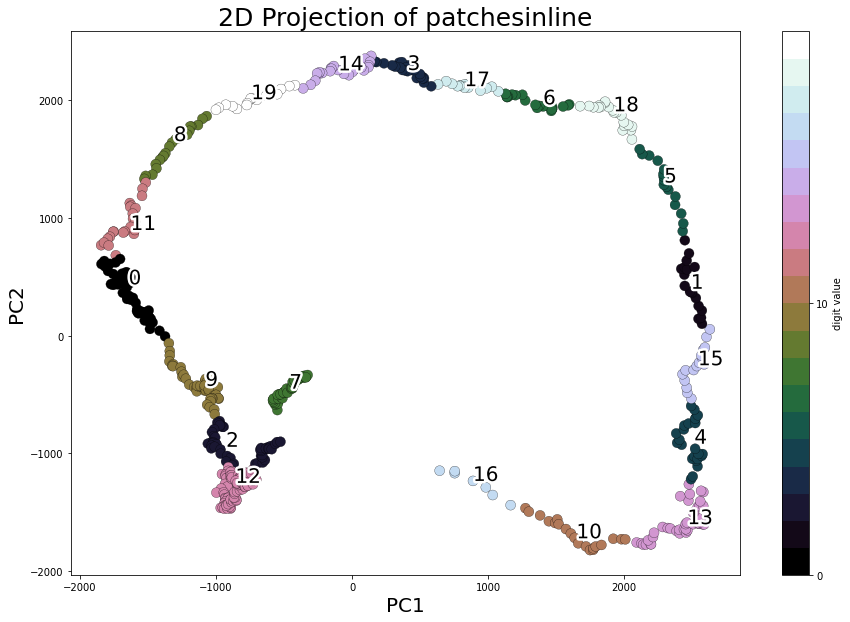

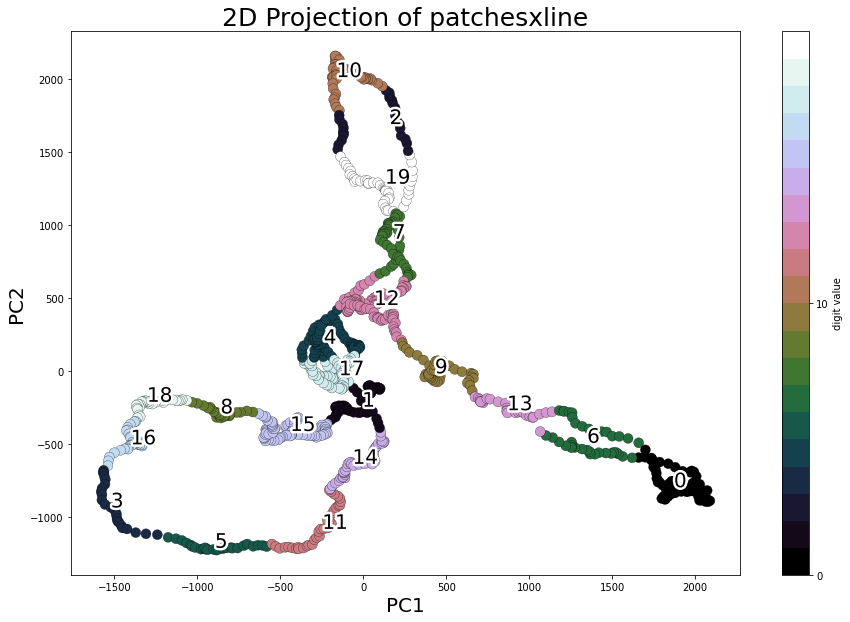

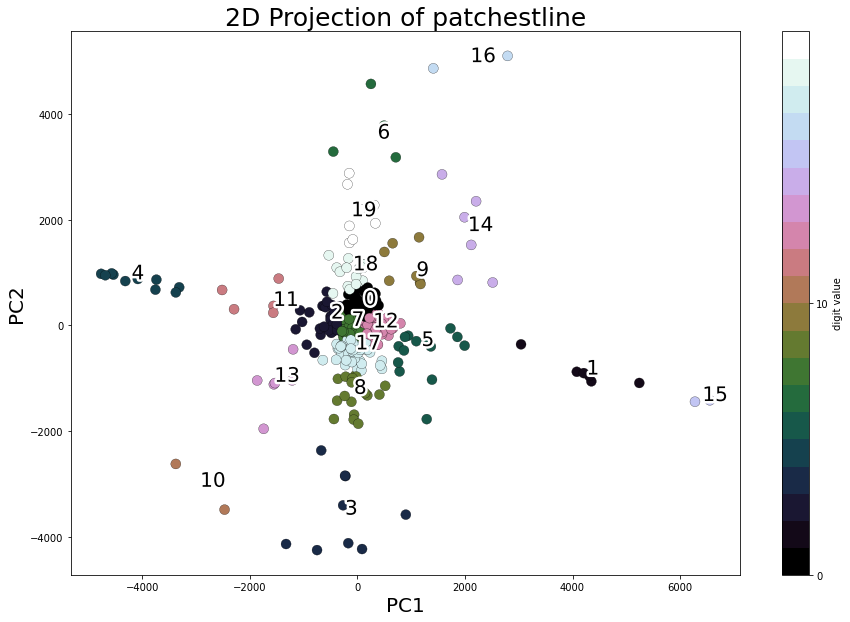

In [4]:
# perform k-means on each dir  to seperate into clusters?
from sklearn.cluster import KMeans

def perform_kmean(data,n_clusters):
    k_means = KMeans(n_clusters, random_state=0)
    k_means.fit(data)
    values = k_means.cluster_centers_.squeeze()
    labels_kmeans = k_means.labels_
    return k_means, values, labels_kmeans
n_clusters = 20

k_means= {}

for dir in directions:
    print("pca[dir]", pca[dir].shape)
    k_means[dir], values, labels_kmeans= perform_kmean(pca[dir],n_clusters)

    # plot 
    scatter(pca[dir], labels_kmeans, n_clusters, dir, output=output_folder +"/pca_kmeans_"+dir+"_"+str(n_clusters)+".png", show_labels=True)

In [6]:
 ## next we need to calculate the median of each cluster 
centers = {}
#print(k_means[dir].cluster_centers_.squeeze(), len(labels_kmeans))
for dir in directions:
    centers[dir] = []
    for i in range(n_clusters):
        x, y = np.median(pca[dir][k_means[dir].labels_ == i, :], axis=0)
        centers[dir].append((x, y, i))
        #print(dir,centers[dir][i])

In [7]:
# then we try to order the closest clusters to a given index 

def euclidean(coords):
    xx, yy,_ = ref
    x, y,_ = coords
    return ((x-xx)**2 + (y-yy)**2)**0.5

cluster_order = {}
for dir in directions:
    ref =centers[dir][0] # choose reference point to be cluster nr 0 
    print(ref)
    centers[dir].sort(key=euclidean)
    cluster_order[dir] = list(map(lambda x: x[-1], centers[dir]) )

    print(dir, cluster_order[dir])

(-1643.7356185768551, 435.7210276154505, 0)
inline [0, 11, 9, 8, 7, 2, 19, 12, 14, 3, 17, 16, 6, 18, 10, 5, 1, 15, 4, 13]
(1872.7323499029558, -794.691056700668, 0)
xline [0, 6, 13, 9, 14, 1, 11, 17, 12, 4, 15, 7, 19, 8, 5, 2, 18, 16, 3, 10]
(117.21344110116873, 381.85378261296773, 0)
tline [0, 7, 12, 2, 18, 17, 9, 5, 11, 8, 19, 13, 14, 6, 3, 1, 4, 10, 16, 15]


REF [[-306.7772695378784, -1186.3374736317107, 11.0, 300.0]]
direction xline
treshold 50



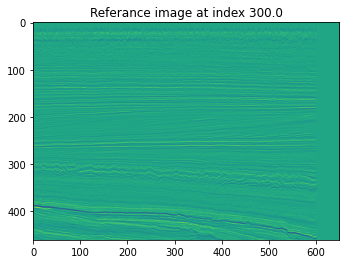

[283.0]

number left  950
most similar img [-168.21461821191974, 2155.8369210295964, 10.0, 583.0]
plot_similar_image 0 583


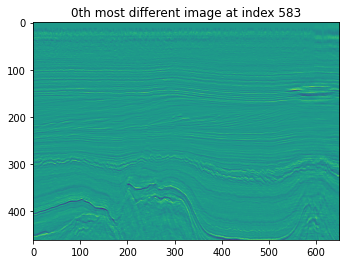

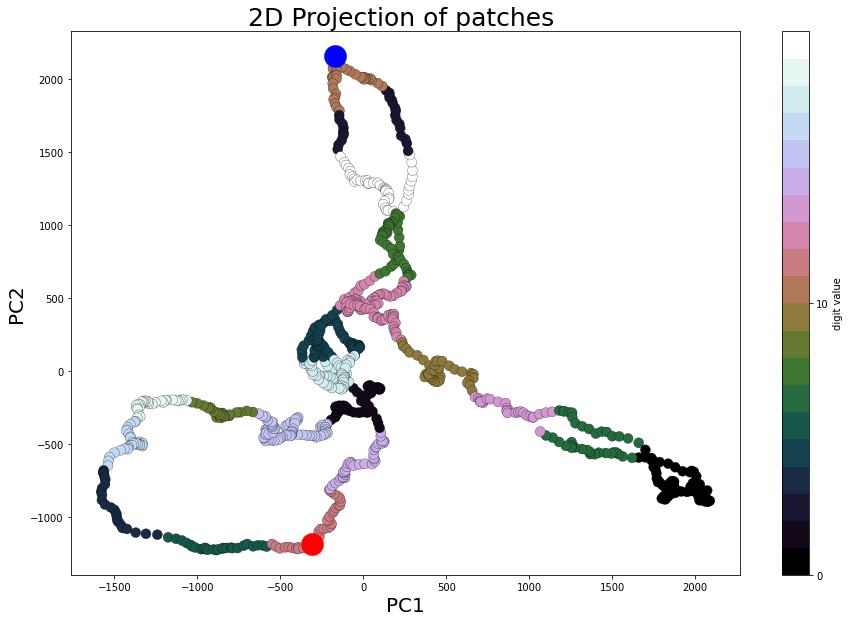

[583.0, 300.0]

number left  949
most similar img [2089.193162083064, -887.2852981688974, 0.0, 883.0]
plot_similar_image 1 883


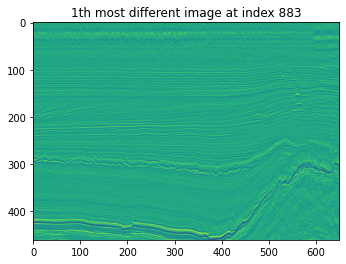

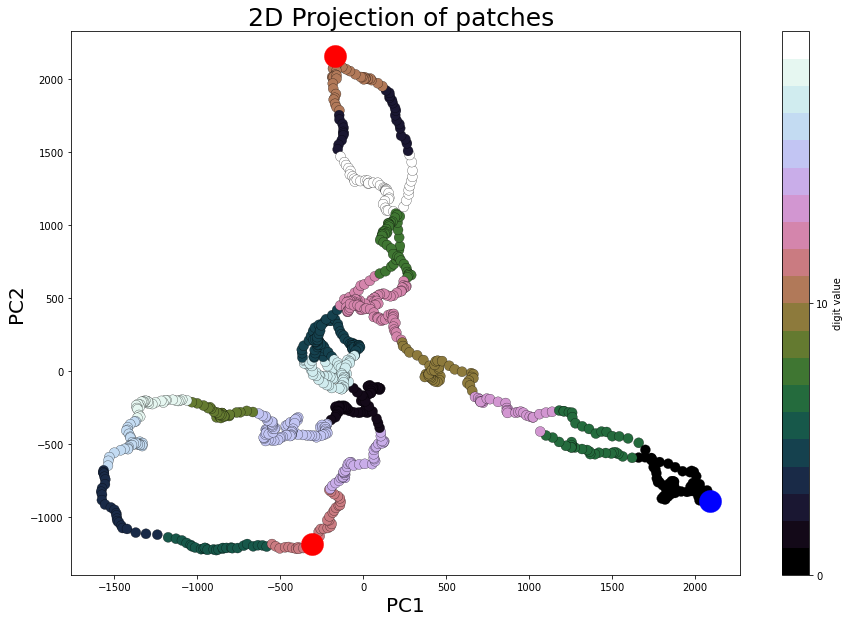

[55.0, 338.0, 638.0]

number left  948
most similar img [-1575.1798157352277, -882.7333630190745, 3.0, 245.0]
plot_similar_image 2 245


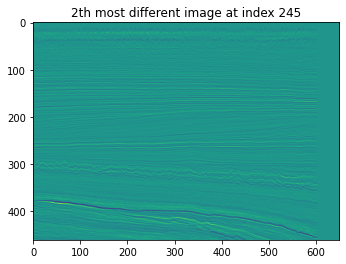

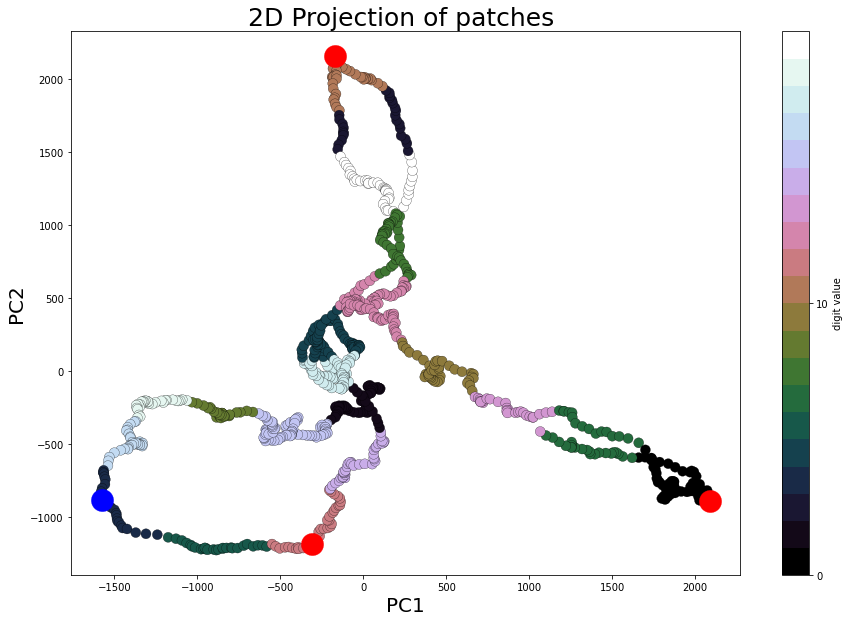

[282.0, 1.0, 301.0, 337.0]

number left  783
most similar img [123.30179336402047, 1253.9405941228988, 19.0, 634.0]
plot_similar_image 3 634


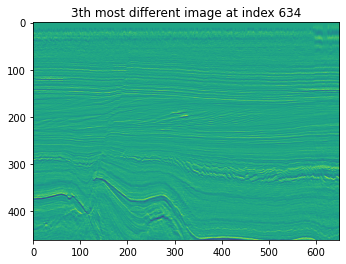

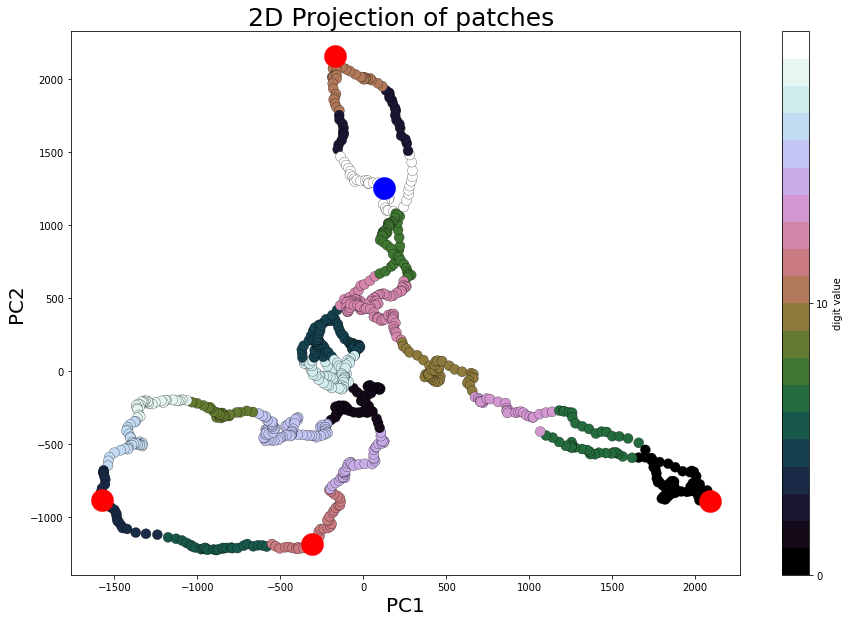

[627.0, 344.0, 44.0, 682.0, 293.0]

number left  755
most similar img [1419.9485953161388, -558.6184614226405, 6.0, 934.0]
plot_similar_image 4 934


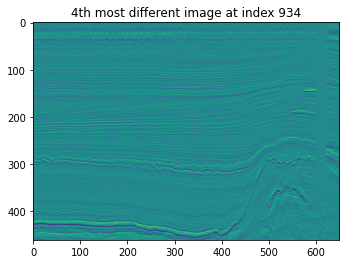

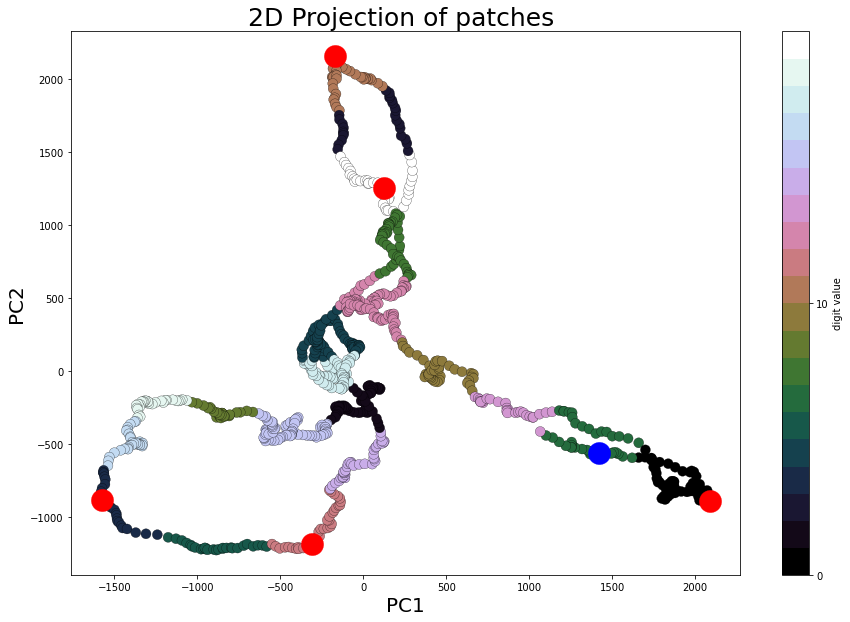

[63.0, 346.0, 646.0, 8.0, 397.0, 697.0]

number left  720
most similar img [-1367.9216972652073, -234.56669458107703, 18.0, 194.0]
plot_similar_image 5 194


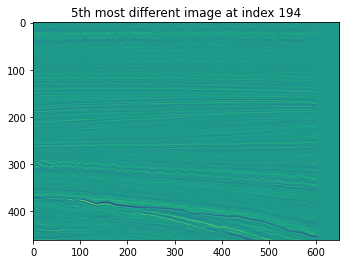

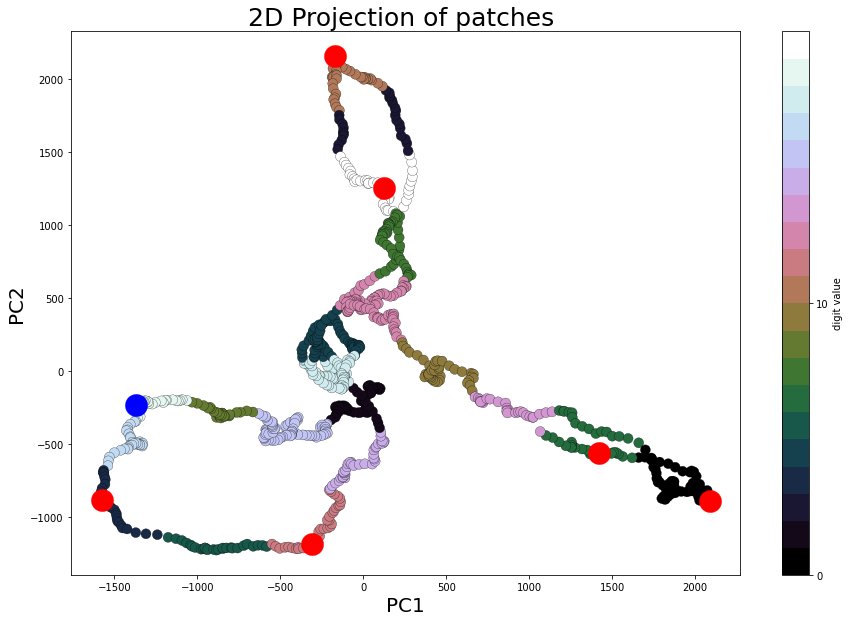

[35.0, 318.0, 618.0, 20.0, 369.0, 669.0, 71.0]

number left  577
most similar img [983.5743125482121, -303.11621364591133, 13.0, 832.0]
plot_similar_image 6 832


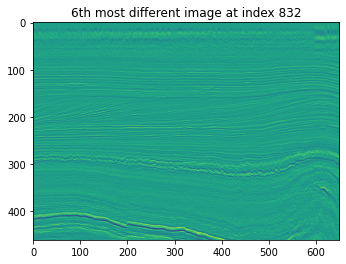

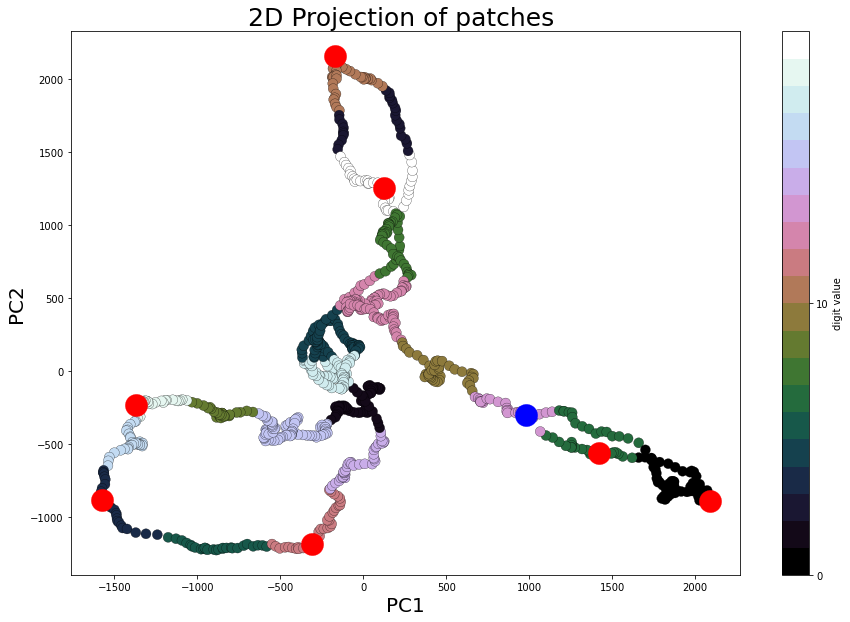

[124.0, 407.0, 707.0, 69.0, 458.0, 758.0, 18.0, 656.0]

number left  526
most similar img [203.75462290988347, 791.7473761176536, 7.0, 532.0]
plot_similar_image 7 532


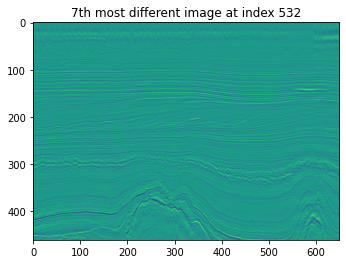

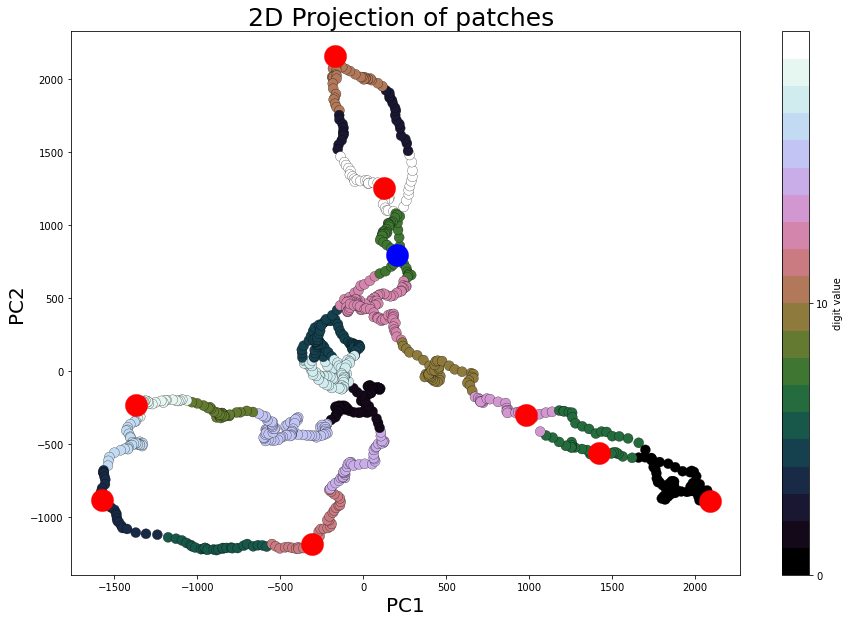

[9.0, 274.0, 574.0, 64.0, 325.0, 625.0, 115.0, 523.0, 223.0]

number left  518
most similar img [-807.4625300769195, -301.5147716928681, 8.0, 143.0]
plot_similar_image 8 143


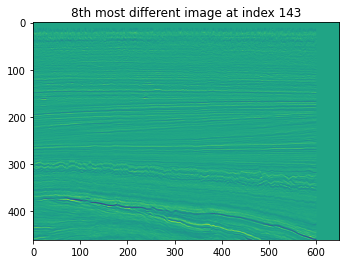

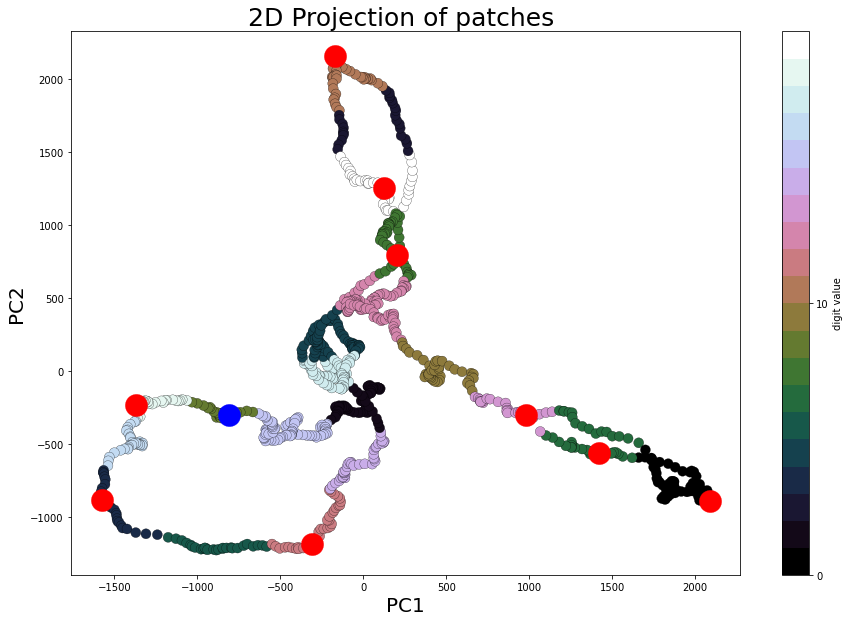

[15.0, 268.0, 568.0, 70.0, 319.0, 619.0, 121.0, 517.0, 217.0, 172.0]

number left  444
most similar img [265.8144355006256, 641.0933786550341, 7.0, 685.0]
plot_similar_image 9 685


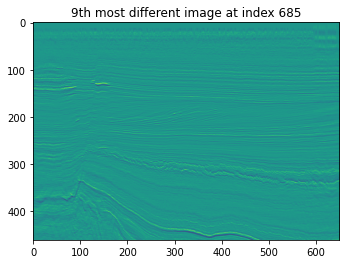

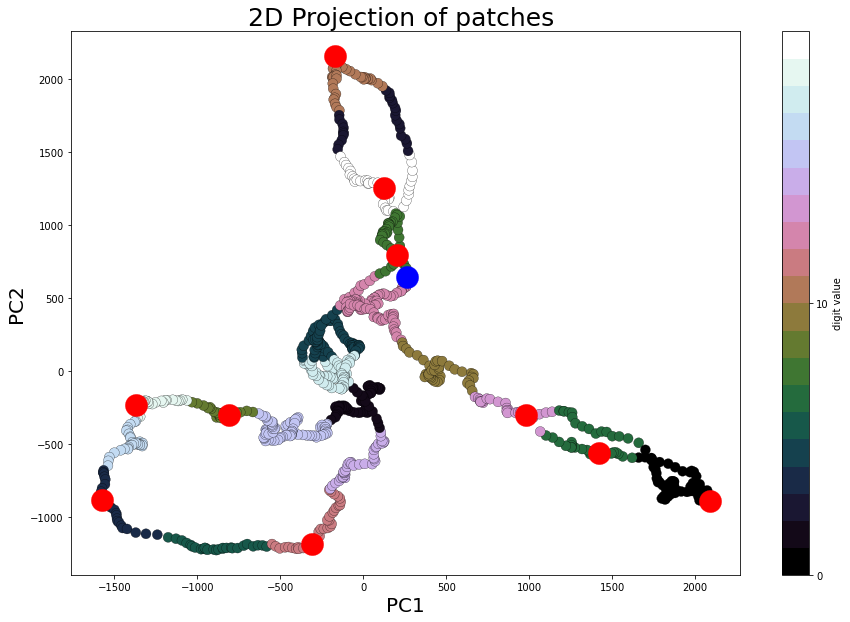

[190.0, 473.0, 773.0, 135.0, 524.0, 824.0, 84.0, 722.0, 422.0, 33.0, 575.0]

number left  424
most similar img [62.849448273531344, -595.0228392294204, 14.0, 351.0]
plot_similar_image 10 351


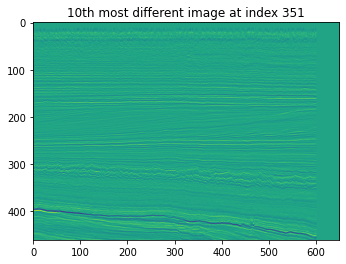

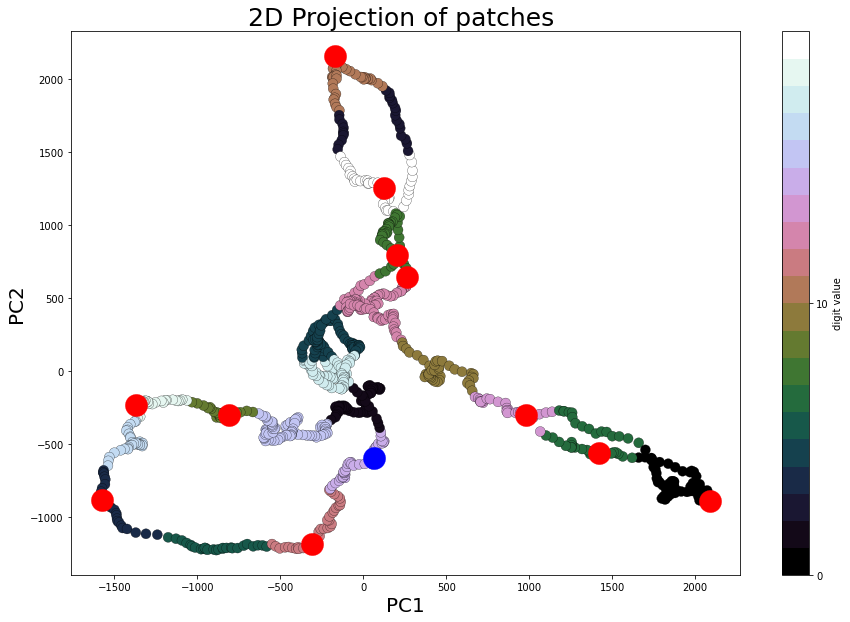

In [5]:
# now we see the indexes of the slices can still be prett close and there is nothing preventing the 10 next slices to be 10* apart.
# Ideally we would find the closest one, remove it from the leist and use it toghet with the previous ref to compute a joint distance
# distance to infer the next slice that is closes to these new points again. 

     
  
direction = "xline"
treshold = 50
# first we group togheter the pca and the slice index labels
pca_cluster_labels = k_means[direction].labels_
pca_index_labels =  np.column_stack((pca[direction], pca_cluster_labels))
pca_index_labels =  np.column_stack((pca_index_labels, labels[direction])) 

ref = [pca_index_labels[300].tolist()]
print("REF", ref)
print("direction", direction)
print("treshold", treshold)

#print(pca[dir][k_means[dir].labels_ == 0, :])
ag = SimilarityImageGenerator(ref, direction, treshold, pca_index_labels)
# plot the original ref
plt.imshow(data[direction][int(ref[0][-1])].reshape(shape[direction][0], shape[direction][1]).T)
plt.title(f'Referance image at index {ref[0][-1]}')
plt.show()

i = 0 
for img in ag:
    
    # for each iteration, we plot the reference and where on the cluster the next image is taken from 
    print("most similar img", img)
    # plot the next image in the sequence
    next_img = data[direction][int(img[-1])].reshape(shape[direction][0], shape[direction][1]).T
    ref_data = np.asarray(ref)
    ref_imgs = 0
    proj= pca[direction]
    proj_labels = k_means[direction].labels_ 
    proj_num_samples = n_clusters
    plot_similar_image(i, int(img[-1]), next_img, ref_imgs, ref_data, proj, proj_labels, proj_num_samples)
    
    i= i+1
    if i > 10:
        break


In [ ]:
## IDEA: this method does not work properly. Could use clustering teqniques to infer the next point in the sequence, but that is difficult.